In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time



In [2]:
# !pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113
import torch

In [3]:
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

%matplotlib inline

In [4]:
print(torch.__version__)


1.11.0+cu113


In [5]:
# google colab does not come with torch installed.
!pip install -q torch==1.0.0 

# Pretrained ConvNets for pytorch: NASNet, ResNeXt, ResNet, InceptionV4, InceptionResnetV2, Xception, DPN, etc.
!pip install -q --upgrade pretrainedmodels

# display live plots while training (loss, accuracy, ROC AUC...)
!pip install -q livelossplot==0.3.3

# display execution time for each cell
!pip install -q ipython-autotime
%load_ext autotime

ERROR: Could not find a version that satisfies the requirement torch==1.0.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0)
ERROR: No matching distribution found for torch==1.0.0


time: 0 ns (started: 2023-04-17 13:02:38 +01:00)


In [6]:
use_cuda = torch.cuda.is_available() 
if use_cuda : 
    print("cuda")
else :
    print("illa")    

cuda
time: 16 ms (started: 2023-04-17 13:02:38 +01:00)


In [7]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
import torch

time: 0 ns (started: 2023-04-17 13:02:38 +01:00)


In [8]:
from IPython.display import HTML
download_images = True #@param ["False", "True"] {type:"raw"}


time: 15 ms (started: 2023-04-17 13:02:38 +01:00)


In [10]:
import pandas as pd
import numpy as np
phases = ['train', 'valid', 'test']
data_root = os.path.join(os.getcwd(), 'data')
data_dir = {phase:os.path.join(data_root, phase) for phase in phases}

time: 16 ms (started: 2023-04-17 13:02:38 +01:00)


In [11]:
def download(url, destination_folder='.'):
  !wget -nc -q --show-progress $url -P $destination_folder

if download_images:
  # download train.zip, valid.zip, test.zip
  for phase in phases:
    download(f'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/{phase}.zip', data_root)

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


time: 62 ms (started: 2023-04-17 13:02:38 +01:00)


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [12]:
import zipfile
from tqdm import tqdm_notebook as tqdm
if download_images:
  # unzip train.zip, valid.zip, test.zip
  for phase in phases:
    if not os.path.exists(data_dir[phase]):
      with zipfile.ZipFile(os.path.join(data_root, f'{phase}.zip'), 'r') as myzip:
        for file in tqdm(myzip.namelist(), desc=f'Extracting {phase}.zip'):
          myzip.extract(member=file, path=data_root)

time: 0 ns (started: 2023-04-17 13:02:39 +01:00)


In [13]:
import glob

classes = [path.split(os.path.sep)[-1] for path in sorted(glob.glob(os.path.join(data_root, 'train', '*')))] if download_images else ['melanoma', 'nevus', 'seborrheic_keratosis']
classes

['melanoma', 'nevus', 'seborrheic_keratosis']

time: 16 ms (started: 2023-04-17 13:02:39 +01:00)


In [14]:
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

def outputDistro(plot=False):
  image_repartition = pd.DataFrame(index=[d.split(os.path.sep)[-1] for d in data_dir.values()], columns=classes)
  plot_data = pd.DataFrame(columns=['Class', 'Phase', 'Count'])
  
  for phase in [d.split(os.path.sep)[-1] for d in data_dir.values()]:
    for disease in classes:

      #   it can be .jpg or .JPG

      # count =  len(glob.glob(os.path.join(data_root, phase, disease, '*.jpg')))
      count =  len(glob.glob(os.path.join(data_root, phase, disease, '*.*')))
      image_repartition.loc[phase][disease] = count
      plot_data = plot_data.append({'Class': disease, 'Phase': phase, 'Count': count}, ignore_index=True)

  image_repartition.loc['TOTAL'] = image_repartition.sum(axis=0)          
  image_repartition['TOTAL'] = image_repartition.sum(axis=1).astype(int)
  image_repartition['Ratio'] = np.round(image_repartition.TOTAL / (image_repartition.TOTAL.sum() - image_repartition.TOTAL[-1]), 2)
  
  if plot:
    sns.set_style("whitegrid")
    sns.barplot(x='Class', y='Count', hue='Phase', data=plot_data, palette='Blues')

  return image_repartition

time: 0 ns (started: 2023-04-17 13:02:39 +01:00)


melanoma nevus seborrheic_keratosis  TOTAL  Ratio
train      374  1372                  254   2000   0.73
valid       30    78                   42    150   0.05
test       117   393                   90    600   0.22
TOTAL      521  1843                  386   2750   1.00

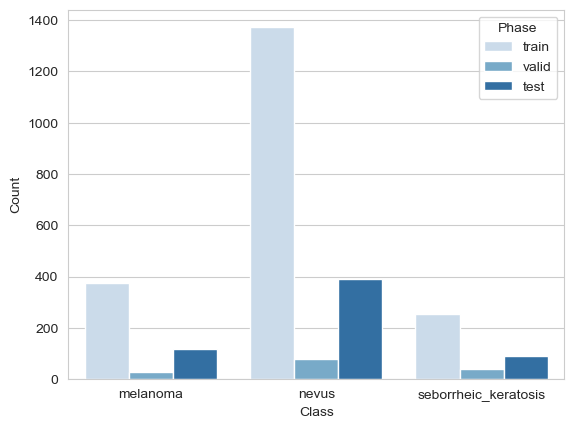

time: 281 ms (started: 2023-04-17 13:02:39 +01:00)


In [15]:
outputDistro(True)

# Downloading More Images


In order to address the imbalance of the dataset, I downloaded more images from the ISIC archive using their CLI interface. Uploading the new data to Google Drive.

In [17]:
import gdown
import zipfile

time: 125 ms (started: 2023-04-17 13:02:39 +01:00)


In [18]:
#Download the file from the id

url = "https://drive.google.com/uc?id="
id = "1Qvw4kvNAVZQvhAETCiObYWsMVHvOcxFh"
output = "melanoma-valid.zip"

# If it doesnt exist, the download will start
if not os.path.exists(output):
    gdown.download(url+id, output, quiet=False)
# gdown.download("https://drive.google.com/file/d/1Qvw4kvNAVZQvhAETCiObYWsMVHvOcxFh")

id = "1QX1yGolI34iWEekfmEWDyL_UORhfUWc_"
output = "melanoma-train.zip"
if not os.path.exists(output):
    gdown.download(url+id, output, quiet=False)

id = "11P0pXWZ7XIKrcMBN_lYRd-SxWb3YEGJz"
output = "melanoma-test.zip"
if not os.path.exists(output):
    gdown.download(url+id, output, quiet=False)

id = "1GeXItCEuVy39wrhH9SD5KixlmgvDHWQZ"
output = "seborrheic_keratosis-valid.zip"
if not os.path.exists(output):
    gdown.download(url+id, output, quiet=False)

id = "1pPQSM3AE7r2a1IiPO56yMzyyKTmhX2Z-"
output = "seborrheic_keratosis-test.zip"
if not os.path.exists(output):
    gdown.download(url+id, output, quiet=False)

id = "1fmrKOfj7heB4n3mRXeFnmkna2E_cfvWW"
output = "seborrheic_keratosis-train.zip"
if not os.path.exists(output):
    gdown.download(url+id, output, quiet=False)

id = "1MJ5G3tsAsOkb7jnDQ_IpRq_La3tY2cgx"
output = "nevus-valid.zip"
if not os.path.exists(output):
    gdown.download(url+id, output, quiet=False)

id = "1NTd9jvDEdHgnVLveVOgB_nxTA_tEalAp"
output = "nevus-test.zip"
if not os.path.exists(output):
    gdown.download(url+id, output, quiet=False)

                          
# With ZipFile
with zipfile.ZipFile("melanoma-valid.zip","r") as zip_ref:
    zip_ref.extractall("/data/valid/melanoma")

# With ZipFile
with zipfile.ZipFile("melanoma-train.zip","r") as zip_ref:
    zip_ref.extractall("/data/train/melanoma")

# With ZipFile
with zipfile.ZipFile("melanoma-test.zip","r") as zip_ref:
    zip_ref.extractall("/data/test/melanoma")

# With ZipFile
with zipfile.ZipFile("seborrheic_keratosis-valid.zip","r") as zip_ref:
    zip_ref.extractall("/data/valid/seborrheic_keratosis")

# With ZipFile
with zipfile.ZipFile("seborrheic_keratosis-test.zip","r") as zip_ref:
    zip_ref.extractall("/data/test/seborrheic_keratosis")

# With ZipFile
with zipfile.ZipFile("seborrheic_keratosis-train.zip","r") as zip_ref:
    zip_ref.extractall("/data/train/seborrheic_keratosis")

# With ZipFile
with zipfile.ZipFile("nevus-valid.zip","r") as zip_ref:
    zip_ref.extractall("/data/valid/nevus")

# With ZipFile
with zipfile.ZipFile("nevus-test.zip","r") as zip_ref:
    zip_ref.extractall("/data/test/nevus")



KeyboardInterrupt: 

time: 15.5 s (started: 2023-04-17 13:02:39 +01:00)


In [19]:
def getUImages(myzip):
  # prevent having any duplicate accross train, valid and test!!!
  
  for image_file in myzip.namelist():
    duplicate = False
    for d in data_dir.values():
      if os.path.exists(f'{d}/{disease}/{image_file}'):
        duplicate = True
    if not duplicate:
      yield image_file

time: 0 ns (started: 2023-04-17 13:02:57 +01:00)


melanoma nevus seborrheic_keratosis  TOTAL  Ratio
train      374  1372                  254   2000   0.73
valid       30    78                   42    150   0.05
test       117   393                   90    600   0.22
more         0     0                    0      0   0.00
TOTAL      521  1843                  386   2750   1.00

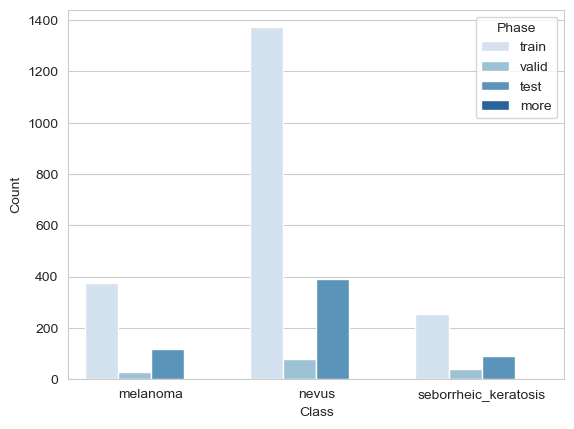

time: 297 ms (started: 2023-04-17 13:02:57 +01:00)


In [21]:
outputDistro(True)

In [22]:
import random

def balance_indices(epoch_indices, y, subset=1):

  images_per_class = {i:[] for i in range(len(classes))}
          
  for i in epoch_indices:
    images_per_class[y[i]].append(i)
  
  counts = [len(indexes) for indexes in images_per_class.values()] 
  max_samples_per_class = int(np.max(counts) * subset)
  if subset < 1:
    logging.info(f'Cold start: reusing {subset*100:.1f}% of images of most represented class')
  
  for i in range(len(classes)):
    if len(images_per_class[i]) > max_samples_per_class:
      images_per_class[i] = random.sample(images_per_class[i], max_samples_per_class)
    else:
      for j in range(max_samples_per_class-len(images_per_class[i])):
        over_sampled_i = np.random.randint(0, counts[i])
        images_per_class[i].append(images_per_class[i][over_sampled_i])
      
  return sorted([item for sublist in images_per_class.values() for item in sublist])

time: 0 ns (started: 2023-04-17 13:02:57 +01:00)


In [23]:
import torchvision.transforms as transforms

def transform(model_name, phase, resize=0.75, n_crops=5):
  image_size = imageSize(model_name)

  if phase=='train':
      return transforms.Compose([
                                  transforms.RandomResizedCrop(image_size, scale=(0.7,1)),
                                  transforms.RandomAffine(degrees=30, translate=(0.2,0.2), scale=(0.8,1.2), shear=(-8,8)),
                                  transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1),
                                  transforms.RandomResizedCrop(224),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  # transforms.Normalize(mean=[0.485, 0.456, 0.406]),
                                  normalise(model_name)
                                  ])

  elif n_crops==1:    
    return transforms.Compose([
                                transforms.Resize(int(image_size/resize)),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                normalise(model_name)])
  else:
    return transforms.Compose([
                                transforms.Resize(int(image_size/resize)),
                                MultiCrop(n_crops, image_size),
                                transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                transforms.Lambda(lambda crops: torch.stack([normalise(model_name)(crop) for crop in crops]))
    ])                                                 


def normalise(model_name):
  
  if model_name.lower() in ['inceptionv4', 'pnasnet5large', 'inceptionresnetv2', 'xception']: #'NasNetALarge']
    return transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
  return transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


time: 0 ns (started: 2023-04-17 13:02:57 +01:00)


In [24]:
import torchvision.models as models
import torch.nn as nn

model_transfer = models.resnet152(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = True

model_transfer.fc = nn.Linear(2048,3)
fc_parameters = model_transfer.fc.parameters()

for param in fc_parameters:
    param.requires_grad = True

use_cuda = torch.cuda.is_available()   

print(model_transfer)
if use_cuda:
    model_transfer = model_transfer.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
def imageSize(model_name):
  
  model_name = model_name.lower()
  

  return 224

time: 0 ns (started: 2023-04-17 13:02:58 +01:00)


In [26]:
def MultiCrop(n_crops, image_size):

  if n_crops == 5:
    return transforms.FiveCrop(image_size)
  elif n_crops == 10:
    return transforms.TenCrop(image_size)
  else:
    raise ValueError(f'Unsupported n_crops: {n_crops}')

time: 16 ms (started: 2023-04-17 13:02:58 +01:00)


In [27]:
import numbers

from torchvision.transforms import functional as F

class TwentyCrop(object):
  """ TenCrop flips image vertically or horizontally. TwentyCrop does both.
  """

  def __init__(self, size):
      self.size = size
      if isinstance(size, numbers.Number):
          self.size = (int(size), int(size))
      else:
          assert len(size) == 2, "Please provide only two dimensions (h, w) for size."
          self.size = size

  def __call__(self, img):

    first_ten = F.ten_crop(img, self.size, vertical_flip=False)
    img = F.vflip(img)
    second_ten = F.ten_crop(img, self.size, vertical_flip=False)

    return first_ten + second_ten

  def __repr__(self):
      return self.__class__.__name__ + '(size={0})'.format(self.size)

time: 0 ns (started: 2023-04-17 13:02:58 +01:00)


In [28]:
def get_n_crops(is_test_phase, metric, n_crops_stages={5: 0.875, 10: 0.890}):

  if is_test_phase:
    for crops, threshold in reversed(sorted(n_crops_stages.items())): 
      if metric >= threshold:
        return crops

  return 1

time: 15 ms (started: 2023-04-17 13:02:58 +01:00)


In [29]:
from PIL import Image, ImageDraw
def preprocess_images(folder, force=False):
  
  if force or folder.endswith('_resized') and not os.path.exists(folder):
    print('For performance purpose, images pre-processing (resizing) is required...')
    
    for dir_name, path in data_dir.items():
      for fn in tqdm(sorted(glob.glob(os.path.join(path, '*', '*.jpg'))), desc=('Resize ' + path.split(os.path.sep)[-1])):
        resized_fn = fn.replace(dir_name, dir_name + '_resized')
        if not os.path.exists(resized_fn):
          if not os.path.exists(os.path.dirname(resized_fn)): 
            os.makedirs(os.path.dirname(resized_fn))
          try:
            im = Image.open(fn)
            # double size required by largest tested model (NASNetALarge)
            size = 331*2, 331*2
            if im.size != size:
              im = im.resize(size, Image.ANTIALIAS)
            im.save(resized_fn)
          except OSError as e:
            print("error " + str(e))

time: 0 ns (started: 2023-04-17 13:02:58 +01:00)


In [30]:
import torch

from torchvision import datasets
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
num_workers = 0
batch_size = {phase: 32 if phase=='train' else 16 for phase in phases}

if download_images:
  image_folders = {phase: datasets.ImageFolder(data_dir[phase], transform=transform('densenet', phase)) for phase in phases}
  loaders = {phase: torch.utils.data.DataLoader(image_folders[phase], batch_size=batch_size[phase], num_workers=num_workers, shuffle=(phase=='train')) for phase in phases}

time: 16 ms (started: 2023-04-17 13:02:58 +01:00)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


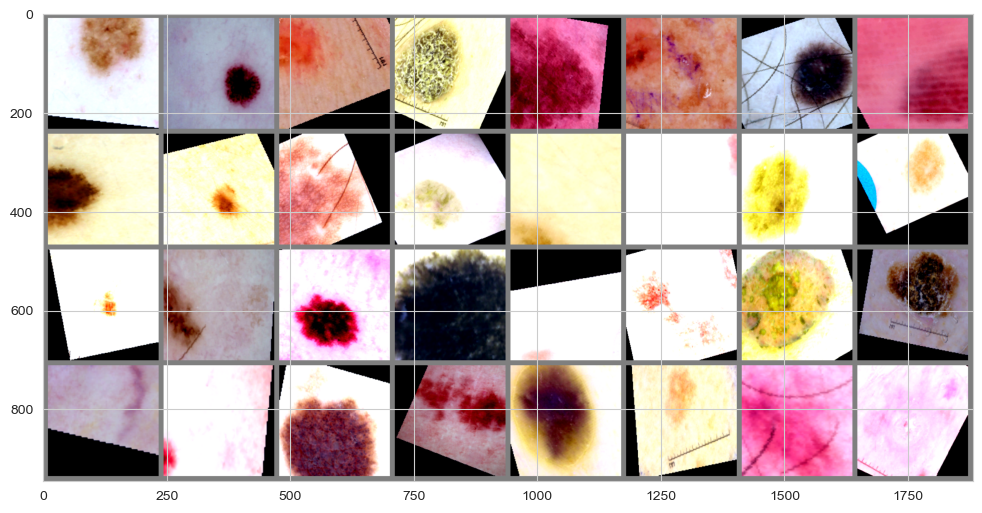

time: 8.39 s (started: 2023-04-17 13:02:58 +01:00)


In [31]:
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
def show_batch(phase, batch_size, nrow):
  
  data_loader = torch.utils.data.DataLoader(image_folders[phase], batch_size=batch_size, num_workers=num_workers, shuffle=(phase=='train'))
  dataiter = iter(data_loader)
  images, labels = next(dataiter)
  
  if len(images.size()) == 5:
    # re-transform multi-crop as 4D tensor for vizualisation
    bs, ncrops, c, h, w = images.size()  
    images = images.view(-1, c, h, w)
  
  fig = plt.figure(figsize=(12, 8))
  imshow(torchvision.utils.make_grid(images, nrow, padding=10))
  
show_batch('train', batch_size=32, nrow=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


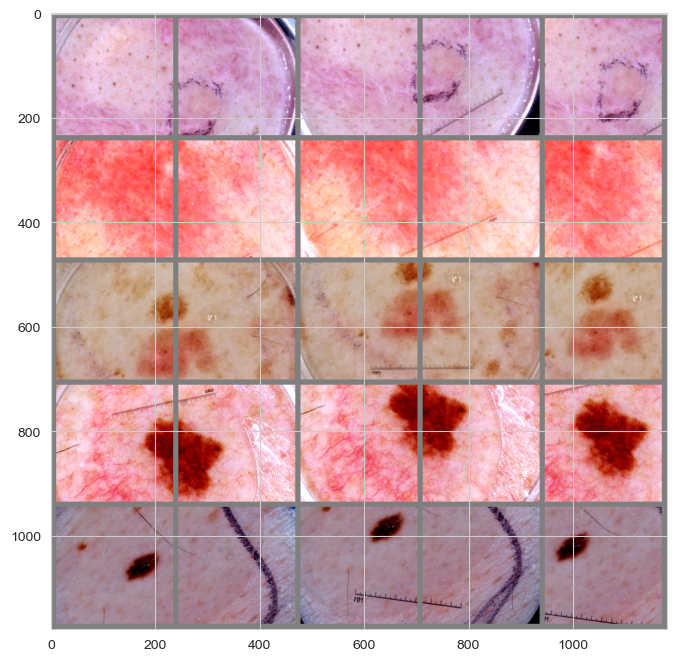

time: 1.61 s (started: 2023-04-17 13:03:07 +01:00)


In [32]:
# shows batch_size * n_crops images
show_batch('test', batch_size=5, nrow=5)

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

time: 0 ns (started: 2023-04-17 13:03:08 +01:00)


In [34]:
import torchvision.models as models
import torch.nn as nn

def set_parameter_requires_grad(parameters, feature_extract):

  
  for param in parameters:
      param.requires_grad = not feature_extract

def configure_model(model, final_classifier, num_classes, feature_extract, skip_requires_grad = False):
  
  if not skip_requires_grad:
    set_parameter_requires_grad(model.parameters(), feature_extract)
    
  return nn.Linear(final_classifier.in_features, num_classes)

time: 0 ns (started: 2023-04-17 13:03:08 +01:00)


In [35]:
import pretrainedmodels

def initialize_model(model_name, num_classes, use_pretrained=False, feature_extract=True):
  
    model = None
    model_name = model_name.lower()


    if model_name == "alexnet":
        """ Alexnet
        """
        model = models.alexnet(pretrained=use_pretrained)
        model.classifier[6] = configure_model(model, model.classifier[6], num_classes, feature_extract)



    elif model_name == "densenet":
        """ Densenet
        """
        model = models.densenet161(pretrained=use_pretrained)
        model.classifier = configure_model(model, model.classifier, num_classes, feature_extract)


    elif model_name in pretrainedmodels.__dict__['model_names']:
        """ pretrainedmodels
        """        
        model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained=('imagenet' if use_pretrained else None))
        model.last_linear = configure_model(model, model.last_linear, num_classes, feature_extract)

    else:
        print(f"Invalid model name: {model_name}, exiting...")
        exit()


    return model.to(device), imageSize(model_name)

time: 750 ms (started: 2023-04-17 13:03:08 +01:00)


In [36]:
def find_first_trained_module(model, start_module_index=np.Inf, start_module_name=None):
  
  for i, (name, module) in enumerate(reversed(list(model.named_modules()))):
    set_parameter_requires_grad(module.parameters(), feature_extract=False)
    if (start_module_name == name or i > start_module_index) and len(list(module.parameters())) > 0:       
      return i, name, get_optimizer(model, name if start_module_name is None else start_module_name)

def set_trained_modules(model, optimizer, epoch, best_epoch, since_epoch, first_trained_module, first_trained_module_i, best_auc, test_phase, fine_tuning_module_rounds=np.Inf):
  
  if (epoch == fine_tuning_module_rounds + best_epoch + 1) or (best_epoch < since_epoch and epoch == fine_tuning_module_rounds + since_epoch + 1) :
    since_epoch = epoch
    first_trained_module_i, first_trained_module, optimizer = find_first_trained_module(model, first_trained_module_i + 1)
    
  logging.info(get_params_to_train_str(model, first_trained_module_i, f' (since epoch {since_epoch:2.0f})', 
                                       fine_tuning_rounds_str = '' if (fine_tuning_module_rounds==np.Inf or epoch==1) else f' ↑ Fine-tuning goes up one module if {test_phase} ROC AUC < {best_auc:.3f} at end of epoch {(best_epoch+fine_tuning_module_rounds) if best_epoch<since_epoch else (since_epoch+fine_tuning_module_rounds):2.0f} ↑ '))

  return since_epoch, first_trained_module_i, first_trained_module, optimizer

time: 15 ms (started: 2023-04-17 13:03:09 +01:00)


In [37]:
def trail_str(str, max_length, last_chars=''):
  
  if len(str) > max_length-2-len(last_chars):
    return str[0:max_length-3] + '...' + last_chars
  return str.ljust(max_length-len(last_chars)) + last_chars
    
def get_params_to_train_str(model, first_trained_module_i, since_epoch_str, fine_tuning_rounds_str=None):
  
  modules = [(('= ' if i > first_trained_module_i else '~ ') + f'{name}') for (i, (name, module)) in enumerate(reversed(list(model.named_modules()))) if name]                                                                                                             
  
  params_to_train, n_params = get_params_to_train(model)  
  total_parameters = len(list(model.parameters()))
  
  feature_extract_modules = modules[first_trained_module_i+1:first_trained_module_i+3] + ['= ...'] + modules[::-1][0:3][::-1]
  feature_extract_modules[0] = trail_str(feature_extract_modules[0], 40)                + f' ↑ Fixed feature extractor on {str(total_parameters-n_params).rjust(4)} parameters out of {str(total_parameters).rjust(4)} in modules above   ↑'
  fine_tuning_modules = modules[0:3] + ['~ ...'] + modules[first_trained_module_i-1:first_trained_module_i+1]
  fine_tuning_modules[-1] = trail_str(fine_tuning_modules[-1], 40, since_epoch_str) + f' ↓ Fine-tuning                {str(n_params).rjust(4)} parameters out of {str(total_parameters).rjust(4)} in modules below   ↓'
  
  return '\n'.join(reversed(feature_extract_modules)) \
      + f'\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~{fine_tuning_rounds_str}~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n' \
       + '\n'.join(reversed(fine_tuning_modules))

def get_params_to_train(model, max_params=6):
  
  params_to_train = list(get_params_to_optimize(model).keys())
  n_params = len(params_to_train)
  
  if n_params > max_params:
    params_to_train = params_to_train[0:max_params//2] + ['...'] + params_to_train[::-1][0:max_params//2][::-1]
  
  return params_to_train, n_params

time: 0 ns (started: 2023-04-17 13:03:09 +01:00)


In [38]:

weight = [1.5, 1, 1]
criterion = nn.CrossEntropyLoss(torch.Tensor(weight).to(device))

time: 0 ns (started: 2023-04-17 13:03:09 +01:00)


In [39]:
def get_params_to_optimize(model):

  params_to_update = {}
  for name,param in model.named_parameters():
      if param.requires_grad == True:
          params_to_update[name] = param
  
  return params_to_update

time: 0 ns (started: 2023-04-17 13:03:09 +01:00)


In [40]:
import torch.optim as optim

def get_optimizer(model, first_fine_tuned_module):

  return optim.Adam(get_optimizer_params_group(model, first_fine_tuned_module), lr=0.001, weight_decay=1e-6)

time: 16 ms (started: 2023-04-17 13:03:09 +01:00)


In [41]:
def get_optimizer_params_group(model, first_fine_tuned_module, classifier_lr=0.001, highest_layer_lr=2*1e-4, lowest_layer_lr=0.5e-4, weight_decay=1e-6):
  
  modules = list(get_top_modules(model, first_fine_tuned_module))
  modules = [m for m in modules if not any((m['name']+'.') in m2['name'] for m2 in modules)]
  learning_rates = list(np.linspace(lowest_layer_lr, highest_layer_lr, len(modules)-1)) + [classifier_lr]
  
  for m, lr in zip(modules, learning_rates):
    yield {'group_name': m['name'], 'params': m['module'].parameters(), 'lr': lr, 'weight_decay': weight_decay}

time: 0 ns (started: 2023-04-17 13:03:09 +01:00)


In [42]:
from collections import OrderedDict
  
def get_top_modules(model, first_fine_tuned_module):
            
  module_names = [f'{name}' for (i8, (name, module)) in enumerate(list(model.named_modules())) if (name and len(list(module.parameters()))>0)]
  top_modules = []
  
  depth=0
  while len(top_modules)<10 and depth<4:
    depth+=1
    top_modules = list(OrderedDict.fromkeys([get_top_module_name(name, depth) for name in module_names]))

  first_fine_tuned_top_module = sorted([m for m in top_modules if m in first_fine_tuned_module], key=len)[-1]

  fine_tuned_modules = top_modules[top_modules.index(first_fine_tuned_top_module):]
  for name in fine_tuned_modules:
    yield {'name': name, 'module': get_sub_module(model, name)}

def get_top_module_name(name, depth=1):
  
  if depth==0: 
    return name
  else:
    return '.'.join(name.split('.')[0:depth]) if name.count('.')>=(depth-1) else get_top_module_name(name, depth-1)
  
def get_sub_module(module, name):
  
  name = name.split('.')
  module = module[int(name[0])] if name[0].isdigit() else getattr(module, name[0])
  
  return module if len(name)==1 else get_sub_module(module, '.'.join(name[1:]))

time: 0 ns (started: 2023-04-17 13:03:09 +01:00)


In [43]:
from sklearn.metrics import roc_curve, auc

def get_roc_auc(y_true, y_pred, plot=False):
    """
    return ROC AUC Score for melanoma, seborrheic_keratosis, and their mean
    """

    # initialize dictionaries and array
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros(3)
    
    # prepare for figure
    if plot:
      plt.figure()
      colors = ['aqua', 'cornflowerblue']

    # for both classification tasks (categories 1 and 2)
    for i in range(2):
        # obtain ROC curve
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i])
        # obtain ROC AUC
        roc_auc[i] = auc(fpr[i], tpr[i])
        if plot:
          # plot ROC curve
          plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                   label='ROC curve for task {d} - class {c} (area = {f:.3f})'.format(d=i+1, c=('melanoma' if i==0 else 'seborrheic_keratosis'), f=roc_auc[i]))
          
    # get score for category 3
    roc_auc[2] = np.average(roc_auc[:2])
    
    if plot:
      # format figure
      plt.plot([0, 1], [0, 1], 'k--', lw=2)
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'ROC curves - (mean area = {roc_auc[2]:.3f})')
      plt.legend(loc="lower right")
      ax = plt.gca()
      ax.set_facecolor('white')
      plt.show()

      # print scores
      for i in range(3):
          print('Category {d} Score: {f:.3f}'. format(d=i+1, f=roc_auc[i]))
        
    return roc_auc

time: 313 ms (started: 2023-04-17 13:03:09 +01:00)


In [44]:
import copy

def save_model(save_path, model, best_epoch_auc):
  # we achieved a higher ROC AUC metric in validation set!
  # let's save it
  
  if save_path is not None:
    logging.info('=> Saving model')
    torch.save(model.state_dict(), save_path.replace('.pt', f'_{best_epoch_auc:.4f}.pt'))
  
  best_model_wts = copy.deepcopy(model.state_dict())                    
  
  return best_model_wts, best_epoch_auc

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [45]:
def load_model(state_dict_fn):
  
  if os.path.exists(os.path.join(os.getcwd(), state_dict_fn)):
    # already downloaded
    state_dict_fn = os.path.join(os.getcwd(), state_dict_fn)
  else:
    state_dict_fn = os.path.join(os.getcwd(), state_dict_fn)
    # download_file(state_dict_fn, quiet=True)
  
  model, image_size = initialize_model(get_model_name(state_dict_fn).lower(), len(classes))
  model.load_state_dict(torch.load(state_dict_fn))
  
  return model

time: 15 ms (started: 2023-04-17 13:03:10 +01:00)


In [46]:
def get_model_name(fn):
  
  model_name = fn.split(os.path.sep)[-1].split('_')[0].split('.')[0]
  
  return f'{model_name}154' if model_name.lower()=='senet' else model_name

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [47]:
def release_model(model):
  # free GPU memory
  
  if model is not None:
    del model
    torch.cuda.empty_cache()

time: 16 ms (started: 2023-04-17 13:03:10 +01:00)


In [49]:
import logging

def init_log(model_name):
  
  # reset handlers
  rootLogger = logging.getLogger()
  rootLogger.handlers = []
  rootLogger.setLevel(logging.INFO)

  # log to file
  save_path = "logs/" + model_name + ".log"
  fileHandler = logging.FileHandler(save_path.replace('.pt', '.log'))
  fileHandler.terminator = '\r\n'
  rootLogger.addHandler(fileHandler)

  # log to console
  consoleHandler = logging.StreamHandler()
  rootLogger.addHandler(consoleHandler)
  
  return save_path

time: 16 ms (started: 2023-04-17 13:03:10 +01:00)


In [50]:
from collections import Counter
  
def log_model_summary(model, criterion, optimizer, phase_data_dirs, over_sampling, cv, start=True, time_elapsed=0):
  
  model_name = model.__class__.__name__
  first_word = 'Start' if start else 'End'
  logging.info(f'{first_word} training {model_name} model')
  
  if not start:
    logging.info('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  
  y = getLables(phase_data_dirs['train'])
  counter = Counter(y)
  logging.info(f'  Class distribution ({np.sum(list(counter.values()))}): ' + ', '.join(f'{count} ' + classes[int(disease)] for disease, count in counter.items()))
  logging.info(f'  Oversampling: {over_sampling}')
  logging.info(f'  Cross validation: {cv}')
  
  #logging.info(f'  Loss function: {criterion} - Weights: {criterion.weight}')
  logging.info(f'  Optimizer: {optimizer}')
  
  train_transforms = transform(model_name, 'train')
  logging.info(f'\n  Train tranforms: {train_transforms}')
  logging.info('')

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [51]:
def update_liveplot(logs, phase, epoch_loss, epoch_acc, epoch_auc):
  ## update data for LiveLossPlot
    
  logs[f'{phase}_log loss'] = epoch_loss
  logs[f'{phase}_accuracy'] = epoch_acc
  logs[f'{phase}_ROC AUC'] = epoch_auc[2]
  
  return logs

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [52]:
def get_running_status(phase, running_loss, running_accuracy):
  progresses = []
  progresses.append(f'{phase}_loss={running_loss/sum(np.array(list(running_accuracy.values()))[:,1]):.3f}')
  progresses.append(f'{phase}_acc={compute_accuracy(running_accuracy):.3f}')
  
  for disease in classes:
    progresses.append(f'{disease[0:5]}_acc={running_accuracy[disease][0]/running_accuracy[disease][1]:.3f}')

  return ', '.join(progresses)

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [53]:
def computeMetrics(inputs, labels, outputs, loss, running_loss, one_hot_labels, outputs_probabilities, running_accuracy):
  # for a given batch it computes the one_hot_labels (one hot encoding)
  # and the probabilities for each class
  
  # use LabelBinarizer instead ? https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html#sklearn.preprocessing.LabelBinarizer
  one_hot_labels = np.append(one_hot_labels, encoding(labels.data.cpu().numpy()), axis=0)

  # track running prediction probabilities
  batch_probabilities = torch.nn.Softmax(dim=1)(outputs.data).cpu().numpy()
  outputs_probabilities = np.append(outputs_probabilities, batch_probabilities, axis=0)
  
  # track running loss
  running_loss += loss.item() * inputs.size(0)
  
  # track running accuracy
  _, predicted_labels = torch.max(outputs, 1)  
  for i, disease in enumerate(classes):
    # nb corrects for disease
    running_accuracy[disease][0] += torch.sum(predicted_labels[labels.data==i]==labels.data[labels.data==i]).cpu().numpy()
    # nb processed for disease
    running_accuracy[disease][1] += labels.data[labels.data==i].size(0)
  
  return running_loss, one_hot_labels, outputs_probabilities, running_accuracy

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [54]:
def encoding(data):
  
  one_hot = np.zeros((data.size, 3))
  one_hot[np.arange(data.size),data] = 1
  
  return one_hot

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


More

In [55]:
# merge train, valid and more folders as cross-validation will be used
phase_data_dirs = {'train': [data_dir[d] for d in sorted(['train', 'valid'])], 
                   'valid': [data_dir[d] for d in sorted(['train', 'valid'])],
                   
                   
                   }

phase_data_dirs_resized = {'train': [data_dir[d] + '_resized' for d in sorted(['train', 'valid'])], 
                           'valid': [data_dir[d] + '_resized' for d in sorted(['train', 'valid'])],
                          
                           }

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [56]:
def getLables(data_dirs):
  # it returns class_id for each sample in the provided folders [0 0 0 1 1 2]
  
  y = []
  for d in data_dirs:
    for class_id, disease in enumerate(classes):
      y = np.append(y, np.full(len(glob.glob(os.path.join(d, disease, '*.jpg'))), class_id))
  return y

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [57]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

def get_kfold_splitter(phase_y, num_epochs, cv=5, test_split=10):
  # return a lambda to create new k-folds every k iterations
  # the lambda will they return the training_indices and validation_indices
    
  X = list(range(len(phase_y['train'])))
  y = phase_y['train']
  
  if test_split is not None:
    # return one single split to have train_and_validation indices, and test split (will never be trained)
    train_valid_indices, test_indices = next(iter(StratifiedKFold(n_splits=test_split).split(X, y)))
    y = [phase_y['train'][i] for i in train_valid_indices]
  else:
    train_valid_indices = X
    test_indices = list(range(len(phase_y['test']))) if 'test' in phase_y else []
  
  rskf = RepeatedStratifiedKFold(n_splits=cv, n_repeats=int(num_epochs/5))
  
  return lambda: [get_phases_indices(train_indices, valid_indices, test_indices) for (train_indices, valid_indices) in rskf.split(train_valid_indices, y)]

time: 16 ms (started: 2023-04-17 13:03:10 +01:00)


In [58]:
def get_split_strategy(phase_y, num_epochs, cv=5, test_split=10):
  
  if cv is None:
    return lambda: [{phase: list(range(len(y))) for (phase, y) in phase_y.items()} for idx in range(num_epochs)]
  
  return get_kfold_splitter(phase_y, num_epochs, cv, test_split) 

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [59]:
def get_phases_indices(train_indices, valid_indices, test_indices):
  
  phases_indices = {'train': train_indices, 'valid': valid_indices}
  
  if len(test_indices) > 0:
    phases_indices['test'] = test_indices
  
  return phases_indices

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [60]:
from torch.utils.data import ConcatDataset

def get_dataset(transform, dirs):
  # it returns as many ImageFolder as we have paths in a given phase 
  # e.g. If cross-validation is used and I have downloaded more data, my training set could have images from 'train', 'valid', and 'more' folders

  dataset = [datasets.ImageFolder(d, transform=transform) for d in dirs]
  
  return dataset[0] if len(dataset)==1 else ConcatDataset(dataset)

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [61]:
from torch.utils.data import SubsetRandomSampler

def get_data_loader(phase, model, folders, indices=None, phase_y=None, over_sampling=False, best_auc=1, n_crops=1, resize=0.75):

  dataset = get_dataset(transform(model.__class__.__name__, phase, resize, n_crops=n_crops), folders)
  
  sampler = None
  
  if indices is not None:
    sampler = SubsetRandomSampler(balance_indices(indices, phase_y['train'], 1) if (over_sampling and phase=='train') else indices)        
  
  return torch.utils.data.DataLoader(dataset, batch_size=batch_size[phase], sampler=sampler, num_workers=num_workers)

time: 16 ms (started: 2023-04-17 13:03:10 +01:00)


In [62]:
import time

from livelossplot import PlotLosses

def train_model(model, criterion, phase_data_dirs, over_sampling=True, num_epochs=25, cv=5, test_split=None, first_trained_module=None, best_auc = 0.0, fine_tuning_module_rounds=np.Inf, n_crops_stages={5: 0.875, 10: 0.890}):

  model, optimizer, first_trained_module_i, save_path, starting_time, best_model_wts, phase_y, split_strategy, live_loss_plot \
    = init_training(model, criterion, phase_data_dirs, num_epochs, over_sampling, cv, test_split, first_trained_module) 
  
  best_epoch = 1
  since_epoch = 1

  try:        
    for epoch, phases_indices in enumerate(split_strategy(), 1):

      logs = {}
      
      current_best_auc = best_auc
      since_epoch, first_trained_module_i, first_trained_module, optimizer = set_trained_modules(model, optimizer, epoch, best_epoch, since_epoch, first_trained_module, first_trained_module_i, best_auc, list(phases_indices.keys())[-1], fine_tuning_module_rounds)

      # Each epoch has a training and validation phase
      for phase, indices in phases_indices.items():
       
        data_loader = init_epoch(model, phase, phase_data_dirs[phase], indices, phase_y, over_sampling, epoch, num_epochs, cv, phase==list(phases_indices.keys())[-1], n_crops_stages=n_crops_stages, best_auc=best_auc)

        # run a single epoch
        logs, best_auc, best_model_wts, _, _ = run_epoch(phase, data_loader, model, criterion, optimizer, logs, best_auc, best_model_wts, save_path.replace('.pt', f'_{first_trained_module}.pt'), save_phase = list(phases_indices.keys())[-1])
        
      if best_auc > current_best_auc:
        best_epoch = epoch
        current_best_auc = best_auc         

      terminate_epoch(live_loss_plot, logs)

  except KeyboardInterrupt:
      logging.info('Training interrupted')
      pass

  log_model_summary(model, criterion, optimizer, phase_data_dirs, over_sampling, cv, False, time.time() - starting_time)

  # load best model weights
  model.load_state_dict(best_model_wts)

  return model

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [63]:
def init_training(model, criterion, phase_data_dirs, num_epochs, over_sampling, cv, test_split, first_trained_module):
  
  preprocess_images(phase_data_dirs['train'][0])
    
  series_fmt = {phases_friendly_names[phase].lower():(f'{phase}_' + '{}') for phase in phase_data_dirs.keys()}
  live_loss_plot = PlotLosses(series_fmt=series_fmt,
                     #mark_high_score={'valid_ROC AUC': 'higher'},
                     validation_fmt=None)

  model = model.to(device)

  save_path = init_log(model.__class__.__name__)

  starting_time = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())  

  phase_y = {phase: getLables(folders) for (phase, folders) in phase_data_dirs.items()}
  split_strategy = get_split_strategy(phase_y, num_epochs, cv, test_split)  
  
  first_trained_module_i, first_trained_module, optimizer = find_first_trained_module(model, start_module_name=first_trained_module)  

  log_model_summary(model, criterion, optimizer, phase_data_dirs, over_sampling, cv, True)
  
  return model, optimizer, first_trained_module_i, save_path, starting_time, best_model_wts, phase_y, split_strategy, live_loss_plot

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [64]:
phases_friendly_names = {'train': 'Training', 'valid': 'Validation', 'test': 'Test'}

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [65]:
def init_epoch(model, phase, folders, indices=None, phase_y=None, over_sampling=False, epoch=None, num_epochs=1, cv=None, is_test_phase=False, n_crops=None, n_crops_stages=None, best_auc=1, resize=0.75):
  
  if n_crops is None:
    n_crops = get_n_crops(is_test_phase, best_auc, n_crops_stages)
  
  fold = '' if cv is None else f'- KFold {cv if (epoch % cv) == 0 else (epoch % cv)}/{cv} '
  crops = '' if phase=='train' else f'{n_crops}-crop' + ('' if n_crops==1 else 's')
  epoch = '' if num_epochs==1 else f'Epoch {epoch}/{num_epochs} '
  logging.info(f'\n{epoch}{fold}{phases_friendly_names[phase]} {crops}')
  
  return get_data_loader(phase, model, folders, indices, phase_y, over_sampling, best_auc, n_crops, resize)

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [66]:
def init_epoch_variables():

  running_loss = 0.0
  
  # {disease: = [nb corrects, nb processed]}
  running_accuracy = {disease:[0, 0] for disease in classes}
 
  # true one hot labels
  one_hot_labels = np.empty((0,3), int)
  
  # predicted outputs probabilities
  outputs_probabilities = np.empty((0,3), float)
  
  return running_loss, running_accuracy, one_hot_labels, outputs_probabilities

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [67]:
# Save the model with torch
def copyModelGD(save_path, model, best_model_wts,auc):
    # save the model

    model_wts = copy.deepcopy(best_model_wts)
    torch.save(model_wts, save_path)
    logging.info(f'Model saved to {save_path}')
    # logging.info(f'Best ROC AUC: {auc:.3f}')
    return model_wts, auc







time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [68]:
def run_epoch(phase, data_loader, model, criterion, optimizer=None, logs={}, best_auc=0.0, best_model_wts=None, save_path=None, save_phase='test'):
  # train, validate or test the model for one epoch
  
  if phase == 'train':
      model.train()  # Set model to training mode
  else:
      model.eval()   # Set model to evaluate mode
      
  # reset epoch metrics
  running_loss, running_accuracy, one_hot_labels, outputs_probabilities = init_epoch_variables()

  # Iterate over data.
  tqdm_items = tqdm(data_loader)
  for inputs, labels in tqdm_items:
      inputs = inputs.to(device)
      labels = labels.to(device)

      if optimizer is not None:
        # zero the parameter gradients
        optimizer.zero_grad()

      # track history if only in train
      with torch.set_grad_enabled(phase == 'train'):
          # forward
          outputs, loss = batch_forward(inputs, labels, model, model.__class__.__name__, criterion, phase)

          # backward + optimize only if in training phase
          if phase == 'train':
              loss.backward()
              optimizer.step()

          # compute and accumulate metrics          
          running_loss, one_hot_labels, outputs_probabilities, running_accuracy \
            = computeMetrics(inputs, labels, outputs, loss, running_loss, one_hot_labels, outputs_probabilities, running_accuracy)
          
          # update progress bar status
          tqdm_items.set_postfix_str(get_running_status(phase, running_loss, running_accuracy))

  epoch_loss = running_loss / len(data_loader.sampler)
  epoch_acc = compute_accuracy(running_accuracy)
  epoch_auc = get_roc_auc(one_hot_labels[:,[0,2]], outputs_probabilities[:,[0,2]])
  
  logging.info('Items processed: {}'.format([f'{disease}: {running_accuracy[disease][1]}' for disease in running_accuracy]))
  logging.info(get_running_status(phase, running_loss, running_accuracy))
  logging.info(f'Cat 1 ROC AUC: {epoch_auc[0]:.3f} Cat 2 ROC AUC: {epoch_auc[1]:.3f} Cat 3 ROC AUC: {epoch_auc[2]:.3f}')

  logs = update_liveplot(logs, phase, epoch_loss, epoch_acc, epoch_auc)

  # deep copy the model
  if phase == save_phase and epoch_auc[2] >= best_auc:
      best_model_wts, best_auc = save_model(save_path, model, epoch_auc[2])
      #Make a checkpoint of the model
      copyModelGD(save_path, model,best_model_wts, epoch_auc[2])
      print(save_path,model,best_model_wts, epoch_auc[2])
      
  return logs, best_auc, best_model_wts, running_accuracy, outputs_probabilities

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [69]:
def compute_accuracy(running_accuracy):
  
  running_accuracy_array = np.array(list(running_accuracy.values()))
  
  return sum(running_accuracy_array[:,0]) / sum(running_accuracy_array[:,1])

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [70]:
def terminate_epoch(live_loss_plot, logs):
  
  live_loss_plot.update(logs)
  live_loss_plot.draw()

  logging.info('')

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [71]:
def batch_forward(inputs, labels, model, model_name, criterion, phase):
  if 'inception3' in model_name.lower() and phase == 'train':
      # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
      outputs, aux_outputs = model(inputs)
      loss1 = criterion(outputs, labels)
      loss2 = criterion(aux_outputs, labels)
      loss = loss1 + 0.4*loss2
  else:
    if len(inputs.size()) == 5:
      inputs_var = torch.autograd.Variable(inputs, volatile=True)

      bs, ncrops, c, h, w = inputs_var.size()  
      temp_output = model(inputs_var.view(-1, c, h, w)) # fuse batch size and ncrops
      outputs = temp_output.view(bs, ncrops, -1).mean(1) # avg over crops
    else:
      outputs = model(inputs)
    
    loss = criterion(outputs, labels)
  
  return outputs, loss

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [72]:
#If a model.pt exists, load it.
def loadModelGD(model_path):
  # load the model
  model = torch.load(model_path)
  logging.info(f'Model loaded from {model_path}')
  return model

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [73]:
def train_densenet_model():

  model, image_size = initialize_model('densenet', len(classes), use_pretrained=True)

  return train_model(model, criterion, phase_data_dirs_resized, over_sampling=True, cv=5, 
                     # Freeze denseblock1 and denseblock2 (feature extraction)
                     # Train  denseblock3 and denseblock4 (fine-tuning)
                     first_trained_module='features.denseblock3', num_epochs=100)


densenetModel = train_densenet_model()

time: 15 ms (started: 2023-04-17 13:03:10 +01:00)


In [102]:
#Load DenseNet.pt and display the roc_auc graphs
densenetModel = loadModelGD("DenseNet.pt")


time: 13.7 s (started: 2023-04-17 13:14:06 +01:00)


In [76]:
def test_model(images_folder, criterion, model=None, resize=0.75, n_crops=10, plot=True, model_fn=None, force_test=False):
  predictions = None
  if model_fn is not None and not force_test:
    predictions, accuracy, best_auc = load_results(model_fn, n_crops, plot)
  if predictions is None:  
    preprocess_images(images_folder)
    if model is None: model = load_model(model_fn)
    # make batch_size inversely proportional to the crop and compatible with biggest models... otherwise CUDA out of memory ;-)
    batch_size['test'] = int(40 / n_crops)
    if len(logging.getLogger().handlers)==1:
      init_log('test')
    data_loader = init_epoch(model, 'test', [images_folder], n_crops=n_crops)
    _, best_auc, _, accuracy, data = run_epoch('test', data_loader, model, criterion)
    file_names = [os.path.basename(fn) for fn in sorted(glob.glob(os.path.join(images_folder, '*', '*.jpg')))]
    predictions = pd.DataFrame(index=file_names, data=data, columns=classes)
    if plot:
      _ = get_roc_auc(y_true, predictions.values, plot=True)
    save_results(model_fn, n_crops, predictions)
  return predictions, accuracy, best_auc, model
plt.rcParams['figure.figsize'] = (8, 6)

time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [77]:


def save_results(model_fn, n_crops, predictions):  
  path_to_save = "results"
  predictions.to_csv(os.path.join(path_to_save, model_fn.replace('.pt', f'-{n_crops}-crops.csv'))) 

  
def load_results(model_fn, n_crops, plot):

  print("Loading results...")
  predictions = None
  accuracy = None
  best_auc = None
  results_fn = model_fn.replace('.pt', f'-{n_crops}-crops.csv')

  if os.path.exists(results_fn):
    if plot: print(f'Loading results from {results_fn}...\n')
    predictions = pd.read_csv(results_fn)
    best_auc,accuracy = compute_scores(predictions[[classes[0],classes[1],classes[2]]].values, plot)
    if plot:
      print(f'        Accuracy: {accuracy:.3f}')
    else:
      print(f'Loaded results from {results_fn}: accuracy = {accuracy:.3f} - ROC AUC Cat3 = {best_auc:0.3f}')
             
  return predictions, accuracy, best_auc
             
def compute_scores(predictions, plot=False):
  combined_roc_auc = get_roc_auc(y_true, predictions[:, [0,2]], plot=plot)[2]
  combined_accuracy = sum(y == np.argmax(predictions, axis=1))/predictions.shape[0]
  return combined_roc_auc, combined_accuracy



time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


In [79]:
def get_ground_truth():
    truth = pd.read_csv('ground_truth.csv')
    y_true = truth.values # convert to numpy array
    y_true = y_true[:, 1:] # remove first column
    y_true = y_true.astype(int) # convert to int
    return y_true

y_true = get_ground_truth()

y = np.argmax([[0, 1, 0] if sum(arr)==0 else arr for arr in np.insert(y_true, 1, 0, axis=1)], axis=1)

time: 16 ms (started: 2023-04-17 13:03:10 +01:00)


Loading results...
Loading results from D:\AI\ai - Copy\results\DenseNet-10-crops.csv...



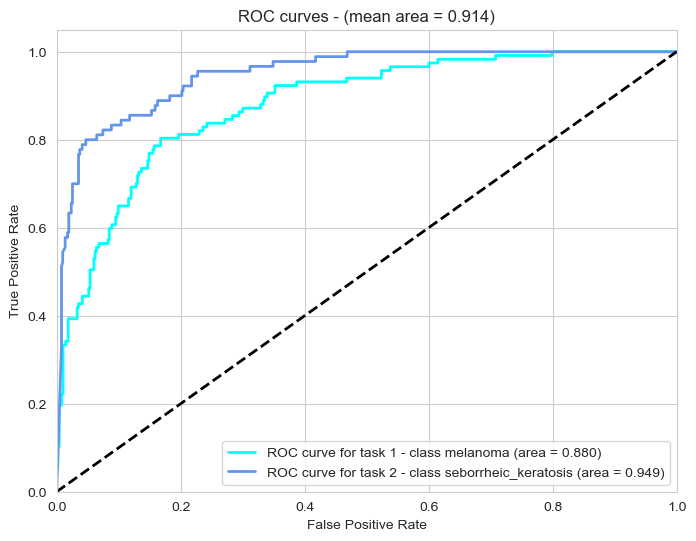

Category 1 Score: 0.880
Category 2 Score: 0.949
Category 3 Score: 0.914
        Accuracy: 0.778
time: 234 ms (started: 2023-04-17 13:03:10 +01:00)


In [80]:
predictions, accuracy, best_auc, densenetModel = test_model(data_dir['test'] + '_resized', criterion, model_fn='DenseNet.pt',)

In [81]:
from sklearn.metrics import confusion_matrix


#Plot the True Positive and False Positive Rates in a confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax










time: 0 ns (started: 2023-04-17 13:03:10 +01:00)


Normalized confusion matrix
[[0.47863248 0.34188034 0.17948718]
 [0.06361323 0.8524173  0.08396947]
 [0.01111111 0.14444444 0.84444444]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

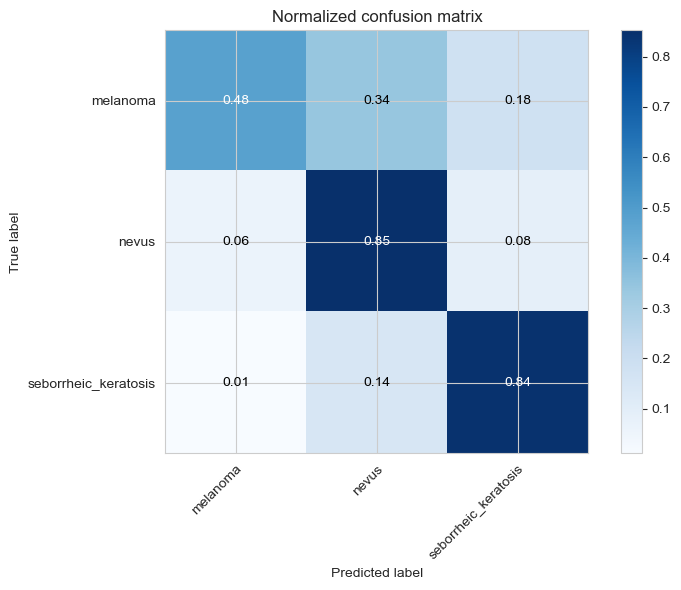

time: 312 ms (started: 2023-04-17 13:03:19 +01:00)


In [83]:
#Plot the True Positive and False Positive Rates in a confusion matrix
plot_confusion_matrix(y, np.argmax(predictions[[classes[0],classes[1],classes[2]]].values, axis=1), classes, normalize=True,
                      title='Normalized confusion matrix')






In [84]:
release_model(densenetModel)

time: 0 ns (started: 2023-04-17 13:03:19 +01:00)


In [85]:
def train_alexnet_model():
    model, image_size = initialize_model('alexnet', len(classes), use_pretrained=True)
    return train_model(model, criterion, phase_data_dirs_resized, over_sampling=True, cv=5,
                       first_trained_module='features', num_epochs=100, fine_tuning_module_rounds=2,
                       n_crops_stages={5: 0.885, 10: 0.900})

# uncomment the code below to train it from scratc~h...
#alexNetModel = train_alexnet_model()



time: 16 ms (started: 2023-04-17 13:03:19 +01:00)


In [ ]:
predictions, accuracy, best_auc, alexNetModel = test_model(data_dir['test'] + '_resized', criterion, model_fn='AlexNet.pt',)

In [ ]:
release_model(alexNetModel)

In [98]:
#Get a sample of the test set to predict on
# data_dir is a dictionary with the following keys: train, valid, test
test_dir = data_dir['test']


# Create a list for the melanoma images
melanoma_files = os.listdir(test_dir + '/melanoma')
melanoma_files = [test_dir + '/melanoma/' + file for file in melanoma_files]

# Create a list for the nevus images
nevus_files = os.listdir(test_dir + '/nevus')
nevus_files = [test_dir + '/nevus/' + file for file in nevus_files]

# Create a list for the seborrheic_keratosis images
seborrheic_keratosis_files = os.listdir(test_dir + '/seborrheic_keratosis')
seborrheic_keratosis_files = [test_dir + '/seborrheic_keratosis/' + file for file in seborrheic_keratosis_files]


# Combine the two lists together in a single list
test_files = melanoma_files + nevus_files + seborrheic_keratosis_files

# Create a list of the class names for the dataset
class_names = ['melanoma', 'nevus', 'seborrheic_keratosis']


# Shuffle the list
random.shuffle(test_files)


#Loads the model
torch.load('DenseNet.pt')

# Create a method to predict the class of an image
def predict_cancer(img_path):
    # Load the image and return the predicted breed
    img = Image.open(img_path)
    transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                    transforms.ToTensor()])
    img = transform(img).unsqueeze(0)
    img = img.to(device)
    model_transfer.eval()
    output = model_transfer(img)
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

    # Print the image label
    # Capatalize the first letter
    print("Prediction: " + class_names[preds].title() + "\n")

    # Print the image filepath
    print("Image Path: " + img_path)

    # Print the image
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.show()
    return class_names[preds]

time: 203 ms (started: 2023-04-17 13:06:19 +01:00)


Prediction: Seborrheic_Keratosis

Image Path: D:\AI\ai - Copy\data\test/nevus/ISIC_0015056.jpg


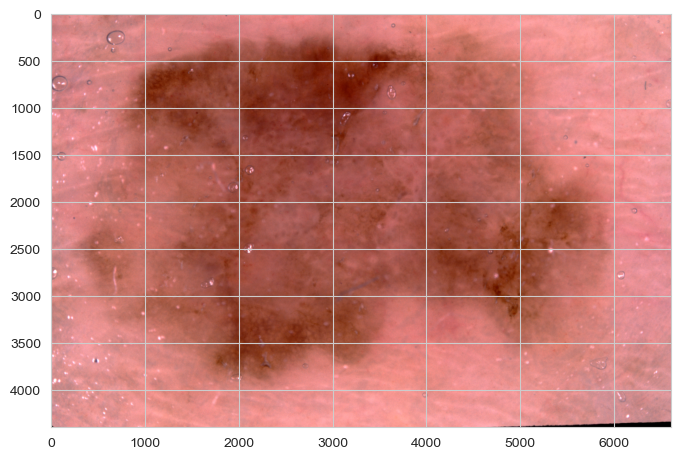

Prediction: Melanoma

Image Path: D:\AI\ai - Copy\data\test/nevus/ISIC_0013109.jpg


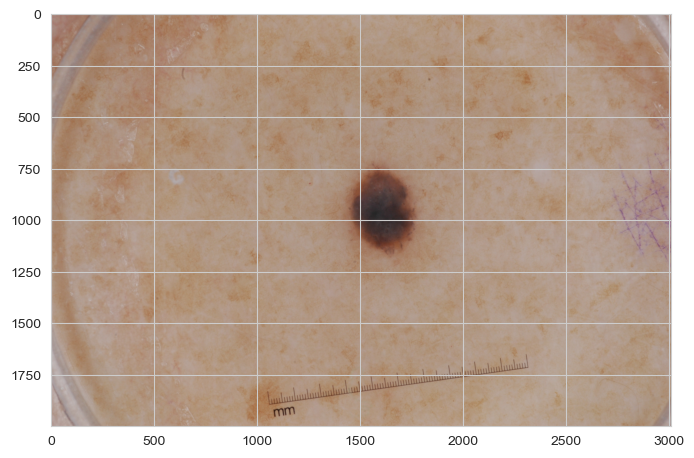

Prediction: Seborrheic_Keratosis

Image Path: D:\AI\ai - Copy\data\test/nevus/ISIC_0013416.jpg


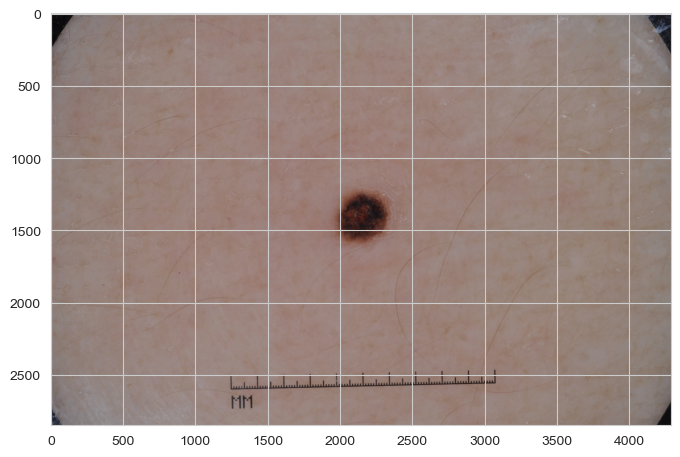

Prediction: Seborrheic_Keratosis

Image Path: D:\AI\ai - Copy\data\test/nevus/ISIC_0015510.jpg


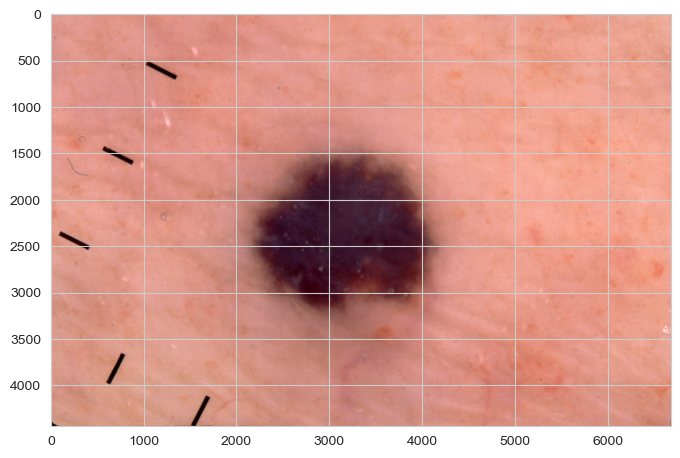

Prediction: Melanoma

Image Path: D:\AI\ai - Copy\data\test/nevus/ISIC_0014961.jpg


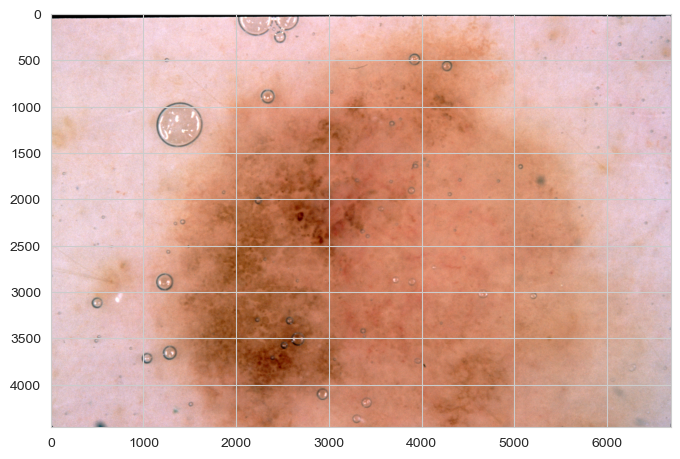

Prediction: Melanoma

Image Path: D:\AI\ai - Copy\data\test/melanoma/ISIC_0014160.jpg


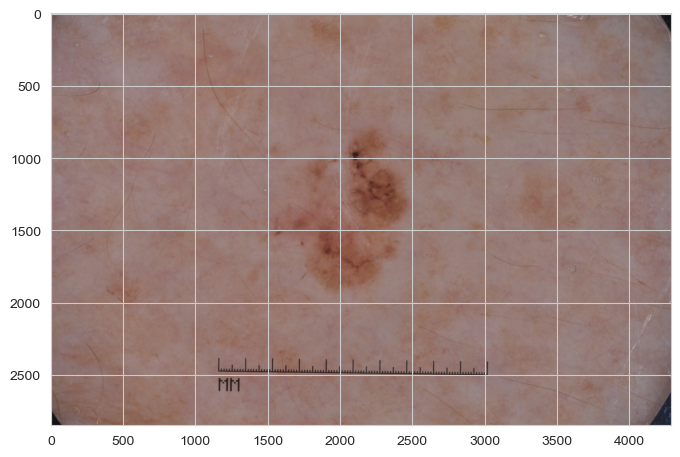

Prediction: Seborrheic_Keratosis

Image Path: D:\AI\ai - Copy\data\test/melanoma/ISIC_0014883.jpg


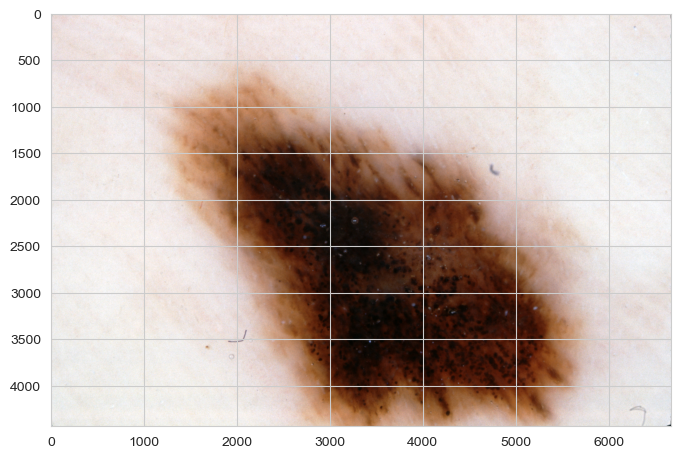

Prediction: Seborrheic_Keratosis

Image Path: D:\AI\ai - Copy\data\test/seborrheic_keratosis/ISIC_0012273.jpg


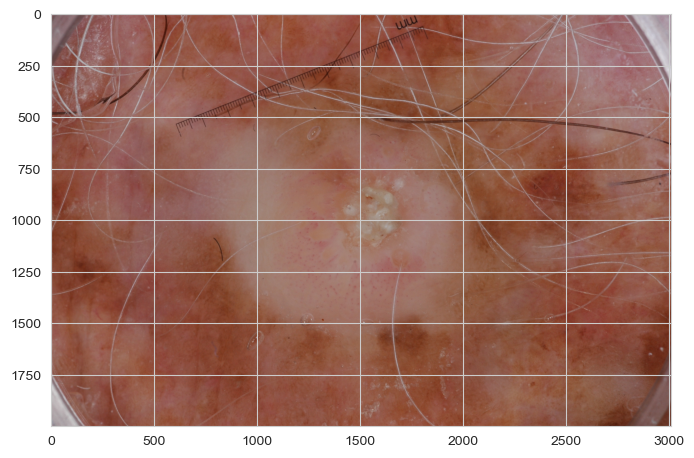

Prediction: Melanoma

Image Path: D:\AI\ai - Copy\data\test/nevus/ISIC_0014973.jpg


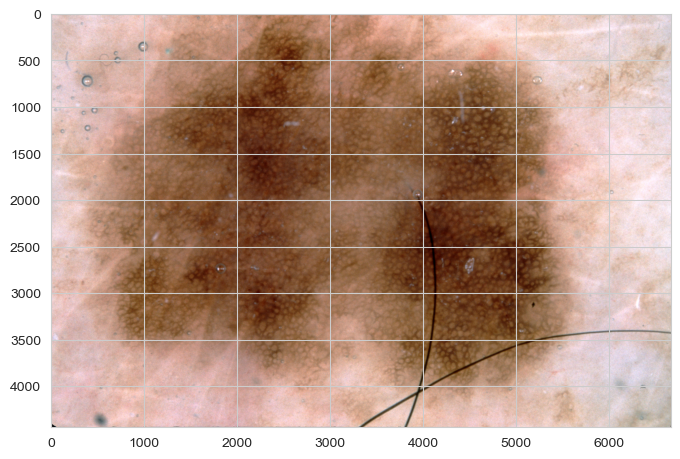

Prediction: Melanoma

Image Path: D:\AI\ai - Copy\data\test/nevus/ISIC_0015202.jpg


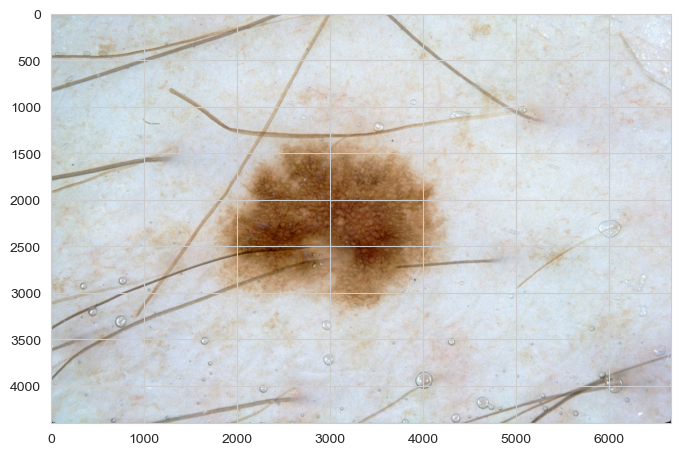

time: 29.9 s (started: 2023-04-17 13:08:33 +01:00)


In [101]:
#Make a prediction on a random image from the test set

# Predict 10 random images from the test set
# Set a random seed
random.seed(777777)

# Select 10 random images from the test set
sample_files = random.sample(test_files, 10)

# Loop through the images and use the model to predict the class
for file in sample_files:
    predict_cancer(file)